## 字詞分類

**Author:** 黃天原
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用SVC、linear regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 大綱
1. 套件說明
2. 文字前處理
    + 2.1 斷句
    + 2.2 斷詞（刪掉次數太少的、標點符號、停用字）
    + 2.3 算出情緒分數，將正負面文章分類
    + 2.4 將情緒標籤加回原本的資料集
    + 2.5 資料集基本檢視
3. 將資料分為測試集和訓練集
    + 3.1 根據7:3的比例切分資料集
4. 將文章轉為 DTM 放入模型訓練
    + 4.1 簡單範例介紹DTM
    + 4.2 套入正式資料集訓練
    + 4.3. 定義建模與畫圖的函數
5. 比較不同模型和資料組合的訓練結果
    + 5.1 logistic regression
    + 5.2 SVC
    + 5.3 decision tree
    + 5.4 預測結果探索

## 分析目標
分析主題：將聯合新聞網三個版別的文章合起來，再用線性模型進行文件的情緒分類，希望分析可以獲得以下資訊：
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：

1. 兩本小說的字詞分部有甚麼不同，代表字詞有哪些？
    +  討論章節：2.4 資料集基本檢視
        + 斷詞、詞性還原後檢視詞頻
    + 討論章節：5.4.1 各字詞特徵的estimate係數
        + 利用建模後的estimate係數挑選各文集代表字
2. 如果用詞頻建立DTM，需不需要篩選詞頻？
    + 討論章節：4.2 套入正式資料集訓練
        + 比較篩詞頻前後的DTM預測效果
3. 此資料集用什麼樣的模型預測，準確率會較高？
    + 討論章節：5.4.3 比較不同模型的ROC
        + 以不同模型的ROC比較準確率

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具
- time: 獲得目前的時間或作時間格式轉換的工具

In [70]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    make_scorer
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [29]:
from matplotlib import font_manager

font_set = {f.name for f in font_manager.fontManager.ttflist}
for f in font_set:
    print(f)

URW Bookman
DejaVu Sans
Liberation Sans Narrow
DejaVu Serif
STIXSizeFourSym
Waree
Lohit Tamil Classical
Noto Sans Mono
Ponnala
Nimbus Roman
padmaa
cmtt10
TenaliRamakrishna
KacstNaskh
ori1Uni
KacstBook
Lohit Bengali
Ramaraja
Lohit Tamil
DejaVu Sans Display
Samyak Gujarati
Uroob
Khmer OS
Kinnari
KacstPen
Ramabhadra
Peddana
Garuda
Rekha
Tlwg Mono
RaghuMalayalamSans
Ani
Umpush
Rasa
KacstArt
LakkiReddy
Dhurjati
KacstPoster
cmr10
Jamrul
Keraleeyam
KacstOffice
Sawasdee
KacstFarsi
FreeSans
URW Gothic
Tlwg Typewriter
Suruma
Phetsarath OT
Likhan
KacstDecorative
P052
Liberation Serif
Noto Sans CJK JP
Navilu
cmex10
Noto Mono
KacstTitle
Sahadeva
Kalapi
Nimbus Sans
C059
Ubuntu
Karumbi
Vemana2000
Rachana
Samyak Malayalam
Pothana2000
Mandali
padmaa-Bold.1.1
aakar
Sree Krushnadevaraya
Gargi
Chilanka
Samyak Tamil
STIXSizeFiveSym
FreeSerif
cmb10
Samyak Devanagari
Manjari
Norasi
Liberation Mono
KacstDigital
Droid Sans Fallback
Gubbi
KacstTitleL
DejaVu Serif Display
FreeMono
Lohit Assamese
Liberation Sans


Text(0.5, 1.0, '聲量圖')

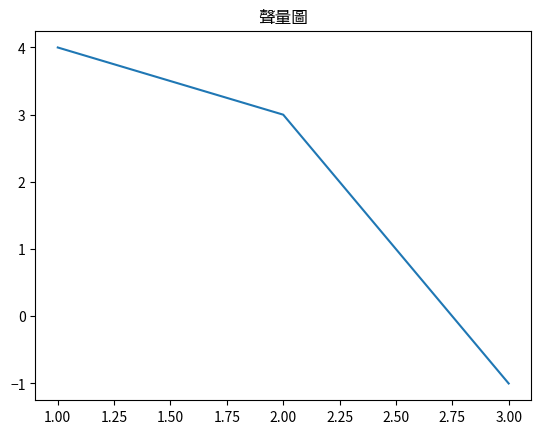

In [30]:
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans CJK JP"]
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理
`udn_news_03.csv`裡面包含了要分析的 udn 新聞資料，在這邊我們先把句子斷開，一個句子代表一個文件(document)，因為每個document需要標上不同的情緒標籤，我們先將每個句子斷詞並用liwc算出情緒分數，為了後面建立 DTM(document-term-matrix) 我們先清理停用字和詞頻太少的句子，並做基本的文件探索。

In [31]:
books = pd.read_csv("raw_data/udn_news_03.csv")  # 匯資料
books.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽／夠經典！大聯盟拍賣網站 潘威倫球衣出價最高,2023-03-01 11:46:00,運動,經典賽,https://udn.com/news/story/10785/7001130,世界棒球經典賽將在3月8日開打，大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標，目前所有...,UDN
1,2,經典賽／神秘巴拿馬30人名單揭曉 5大聯盟+1前中職洋投,2023-03-01 12:09:00,運動,經典賽,https://udn.com/news/story/10785/7001237,世界棒球經典賽將在3月8日開打，中華隊首戰對手巴拿馬隊今天公布最終30人名單，其中有5名現役...,UDN
2,3,經典賽／大谷翔平發文宣告與日本隊合體 何時出賽還不確定,2023-03-01 17:21:00,運動,經典賽,https://udn.com/news/story/10785/7002171,世界棒球經典賽將在下周3月8日開打，將代表日本出征的大谷翔平今天進行春訓初登板，賽後馬上啟程...,UDN


In [32]:
# 看看有幾篇文章
print(f"number of posts: {books.shape[0]}")
print(f"date range: {(books['artDate'].min(), books['artDate'].max())}")
print(f"category: \n{books['artCatagory'].value_counts()}")


number of posts: 5985
date range: ('2023-03-01 07:00:00', '2023-03-31 23:39:00')
category: 
股市    2211
運動    2009
兩岸    1765
Name: artCatagory, dtype: int64


### 2.文字前處理
+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）
+ 2.3 算出情緒分數，將正負面文章分類
+ 2.4 將情緒標籤加回原本的資料集

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [33]:
# 移除網址格式
books["artContent"] = books.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
books["artTitle"] = books["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
books["artContent"] = books.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
books["artTitle"] = books["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
books.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高,2023-03-01 11:46:00,運動,經典賽,https://udn.com/news/story/10785/7001130,世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標目前所有拍賣物品...,UDN
1,2,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投,2023-03-01 12:09:00,運動,經典賽,https://udn.com/news/story/10785/7001237,世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今天公布最終人名單其中有名現役大聯盟球員還有...,UDN
2,3,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定,2023-03-01 17:21:00,運動,經典賽,https://udn.com/news/story/10785/7002171,世界棒球經典賽將在下周月日開打將代表日本出征的大谷翔平今天進行春訓初登板賽後馬上啟程返日準備...,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [34]:
# 留下 content
books["content"] = books["artTitle"] + books["artContent"]
data = books[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
data.head()

,content,artUrl,artCatagory
0,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出...,https://udn.com/news/story/10785/7001130,運動
1,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今...,https://udn.com/news/story/10785/7001237,運動
2,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定世界棒球經典賽將在下周月日開打將代表日本出...,https://udn.com/news/story/10785/7002171,運動
3,經典賽鄧愷威搭上飛機了日會合中華隊日登板旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表...,https://udn.com/news/story/10785/7002266,運動
4,經典賽古巴隊會藏中華隊餅總保持戒心古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊...,https://udn.com/news/story/10785/7002313,運動


In [35]:
# 看看有幾篇文章
print(f"total docs: {data.shape[0]}")


total docs: 5985


### 2.2 斷詞

In [36]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [37]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [38]:
data["words"] = data["content"].apply(getToken).map(" ".join)
data.head()

Building prefix dict from /home/evan19983314/SMA/SMA_2023S/week11_classification/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.uf86e896fa1a801cc442cbab0bb7b6f1d.cache
Loading model cost 1.794 seconds.
Prefix dict has been built successfully.
/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,content,artUrl,artCatagory,words
0,經典賽夠經典大聯盟拍賣網站潘威倫球衣出價最高世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出...,https://udn.com/news/story/10785/7001130,運動,經典 賽夠 經典 聯盟 拍賣 網站 潘威倫 球衣 出價 最高 世界 棒球 經典 賽將 開打 ...
1,經典賽神秘巴拿馬人名單揭曉大聯盟前中職洋投世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今...,https://udn.com/news/story/10785/7001237,運動,經典 神秘 巴拿馬人 名單 揭曉 聯盟 中職 洋投 世界 棒球 經典 賽將 開打 中華隊 首...
2,經典賽大谷翔平發文宣告與日本隊合體何時出賽還不確定世界棒球經典賽將在下周月日開打將代表日本出...,https://udn.com/news/story/10785/7002171,運動,經典 大谷 翔平 發文 宣告 日本隊 合體 出賽 還不 確定 世界 棒球 經典 賽將 下周 ...
3,經典賽鄧愷威搭上飛機了日會合中華隊日登板旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表...,https://udn.com/news/story/10785/7002266,運動,經典 鄧愷威 飛機 會合 中華隊 日登板 旅美 投手 鄧愷威 加入 中華隊 時間 出爐 總教...
4,經典賽古巴隊會藏中華隊餅總保持戒心古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊...,https://udn.com/news/story/10785/7002313,運動,經典 古巴隊 會藏 中華隊 餅總 保持 戒心 古巴隊 昨天 擊敗 味全 下來 熱身賽 首勝 ...


### 2.3 資料集基本檢視

檢視資料內容

In [39]:
print(f"total posts: {len(data['artUrl'].unique())}")
print(f"category: \n{data['artCatagory'].value_counts()}")


total posts: 5985
category: 
股市    2211
運動    2009
兩岸    1765
Name: artCatagory, dtype: int64


## 3. 將資料切成訓練集與測試集
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [40]:
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train)
print(y_train)

1576    杜拜 網賽 克維奇 輸給 梅德維夫 今年 連勝 句點 塞爾維亞 網球 名將 克維奇 今天 杜...
3944    宏捷科 目標價 大摩喊 摩根士丹利 砷化鎵 產業 智慧 手機 功率 放大器 出貨量 有所 轉...
1366    喬治 膝傷 不用 開刀 樂觀 季後賽 首輪 歸隊 快艇 當家 球星 喬治 昨天 傳出 右膝 ...
713     經典 彈力 惡夢 悄悄 襲來 中華隊 熱身賽 全勝 無法 樂觀 第屆 經典 賽組 預賽 台灣...
5951    河南 名校 女靠 拾荒 月入 破萬稱 實現 財務 自由 河南 有個 名校 畢業 女生 毅然 ...
                              ...                        
2687    台股 收漲點 創個 新高 線長 紅台 今天 電子 傳產及 生技力 之下 指數 碎步 走高 盤...
5789    阿里 日子 裡馬 一年 低調 研究 魚和 糧食 曾經 一家 科技 巨頭 老闆 現在 正在 研...
2119    今年 利率 亮眼 專家 介紹 高息 低波 今年以來 利率 表現 亮眼 幾檔 高息 低波 關注...
4017    華城 中興 認購 聯合國 世界氣象組織 指出 連續 肆虐 三年 聖嬰 現象 告終 聖嬰 現象...
2982    萬海 去年 元將 配元 現金 股利 利率 萬海 考量 通膨及 衝突 地緣 政治 因素 影響 ...
Name: words, Length: 4189, dtype: object
1576    運動
3944    股市
1366    運動
713     運動
5951    兩岸
        ..
2687    股市
5789    兩岸
2119    股市
4017    股市
2982    股市
Name: artCatagory, Length: 4189, dtype: object


In [41]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
股市    36.942356
運動    33.567251
兩岸    29.490393
Name: artCatagory, dtype: float64

train percentage :
股市    36.619718
運動    33.802817
兩岸    29.577465
Name: artCatagory, dtype: float64

test percentage :
股市    37.694878
運動    33.017817
兩岸    29.287305
Name: artCatagory, dtype: float64


## 4. 將文章轉為 DTM
+ 4.1 簡單範例介紹DTM
+ 4.2 套入正式資料集訓練

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)
    + ngram_range: unigrams and bigrams

### 4.1 簡單範例介紹DTM

在這裡我們用簡單的四個中文句子，建立一個 DTM，在這裡我們利用 `CountVectorizer` 計算出不同句子的詞頻，再轉換成DTM。DTM裡面每個row代表一個句子，每個column代表一個詞出現的次數，在這邊我們可以設定`ngram_range`參數，讓句子考慮到前後單詞的組合。

### 4.2 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

+ 過濾詞頻比較

In [42]:
# 沒有過濾最低詞頻的 vectorizer
vectorizer = CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
print(vectorizer)
vectorizer.fit(X)
vec_train = vectorizer.transform(X_train)

print(vectorizer.get_feature_names())
print(vec_train.toarray())


CountVectorizer(max_features=10000)
['一一', '一三壘', '一下', '一中', '一事', '一些', '一人', '一件', '一份', '一位', '一個月', '一倍', '一共', '一再', '一出', '一分', '一到', '一刻', '一勝', '一勝帶', '一半', '一卡通', '一口', '一口氣', '一句', '一台', '一同', '一名', '一向', '一周', '一員', '一哥', '一圈', '一國兩制', '一城', '一堆', '一場', '一塊', '一壘', '一壘手', '一大', '一天', '一套', '一如', '一姊戴', '一姐', '一季', '一定', '一家', '一對', '一局', '一屆', '一層', '一席', '一帶', '一幕', '一年', '一年一度', '一度', '一座', '一張', '一成', '一戰', '一批', '一把', '一擊', '一支', '一敗', '一方', '一旁', '一日', '一早', '一是', '一時', '一月', '一朗', '一期', '一根', '一條', '一條龍', '一棒', '一檔', '一次', '一次性', '一款', '一步', '一段', '一段時間', '一波', '一波接', '一流', '一片', '一環', '一生', '一發', '一盤', '一直', '一種', '一站', '一站式', '一筆', '一篇', '一系列', '一級', '一組', '一線', '一群', '一職', '一股', '一致', '一舉', '一處', '一行', '一言', '一記', '一貫', '一起', '一趟', '一路', '一路上', '一路領先', '一輛', '一輩子', '一輪', '一連', '一連串', '一週', '一道', '一邊', '一部', '一部分', '一間', '一隻', '一雙', '一面', '一面倒', '一項', '一顆', '一體化', '一點', '一點點', '七個', '七局', '七年', '七成', '丈夫', '三人', '三位', '三個', '三倍', '三分', '三分之一', '三分球', '三名', '三吞敗', '三

In [43]:
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)


(4189, 10000)
(1796, 10000)


In [44]:
# 定義分類器模型
clf = LogisticRegression(multi_class="multinomial").fit(vec_train, y_train)
clf

LogisticRegression(multi_class='multinomial')

In [45]:
clf.classes_


array(['兩岸', '股市', '運動'], dtype=object)

In [46]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
# one-hot encoding
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(1796, 3)

In [47]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.99      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '兩岸'), Text(0, 1.5, '股市'), Text(0, 2.5, '運動')])

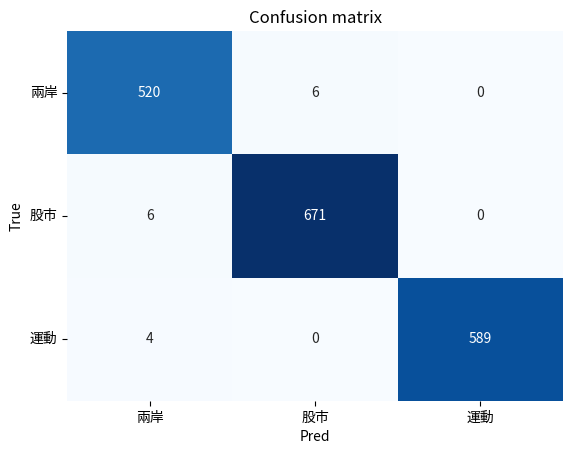

In [50]:
classes = clf.classes_
## Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

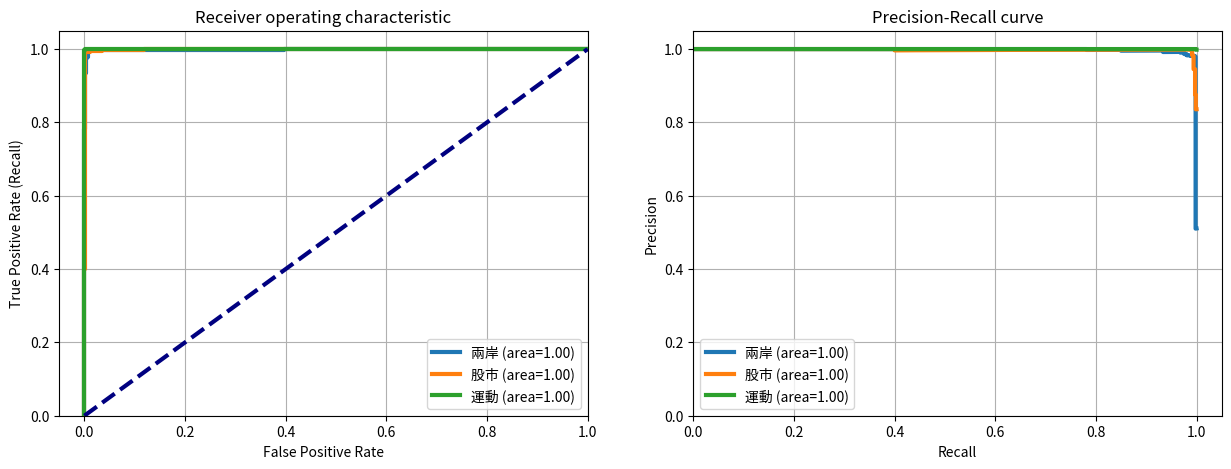

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()


#### CV

In [71]:
cv_results = cross_validate(clf, vec_train, y_train, cv=5, return_train_score=True)
cv_results

{'fit_time': array([0.71511936, 0.8216362 , 0.72842646, 0.53469586, 0.56832981]),
 'score_time': array([0.00282836, 0.00244427, 0.00212908, 0.00144267, 0.0014472 ]),
 'test_score': array([0.99045346, 0.98568019, 0.98448687, 0.99045346, 0.98805257]),
 'train_score': array([1., 1., 1., 1., 1.])}

### tfidf

In [52]:
model = Pipeline(
    [
        ("vectorizer", TfidfVectorizer(max_features=10000)),
        ("classifier", clf),
    ]
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          兩岸       0.98      0.99      0.99       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



In [53]:
vec = TfidfVectorizer(max_features=10000).fit_transform(X_train).toarray()

In [54]:
vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 比較不同模型效果

In [55]:
# 定義模型訓練組合
## pipeline: 分類器 + 資料處理 vectorizer
def train(vectorizer, clf, X_train, y_train, X_test, y_test):

    ## train classifier
    vec_train = vectorizer.fit_transform(X_train).toarray()
    vec_test = vectorizer.transform(X_test).toarray()
    clf.fit(vec_train, y_train)

    ## test classifier
    y_pred = clf.predict(vec_test)
    y_pred_proba = clf.predict_proba(vec_test)

    ## Accuracy, Precision, Recall, F1-score
    print(classification_report(y_test, y_pred))

    classes = clf.classes_
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0].plot(
            fpr,
            tpr,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr)),
        )
    ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
    ax[0].set(
        xlim=[-0.05, 1.0],
        ylim=[0.0, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate (Recall)",
        title="Receiver operating characteristic",
    )
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1].plot(
            recall,
            precision,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
        )
    ax[1].set(
        xlim=[0.0, 1.05],
        ylim=[0.0, 1.05],
        xlabel="Recall",
        ylabel="Precision",
        title="Precision-Recall curve",
    )
    ax[1].legend(loc="best")
    ax[1].grid(True)

    plt.show()

    # return the model object
    return classification_report(y_test, y_pred, output_dict=True)

now training: clf_logistic
              precision    recall  f1-score   support

          兩岸       0.98      0.99      0.99       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      1.00       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



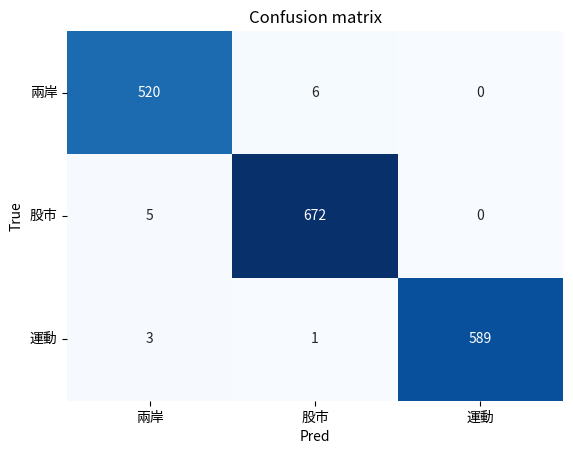

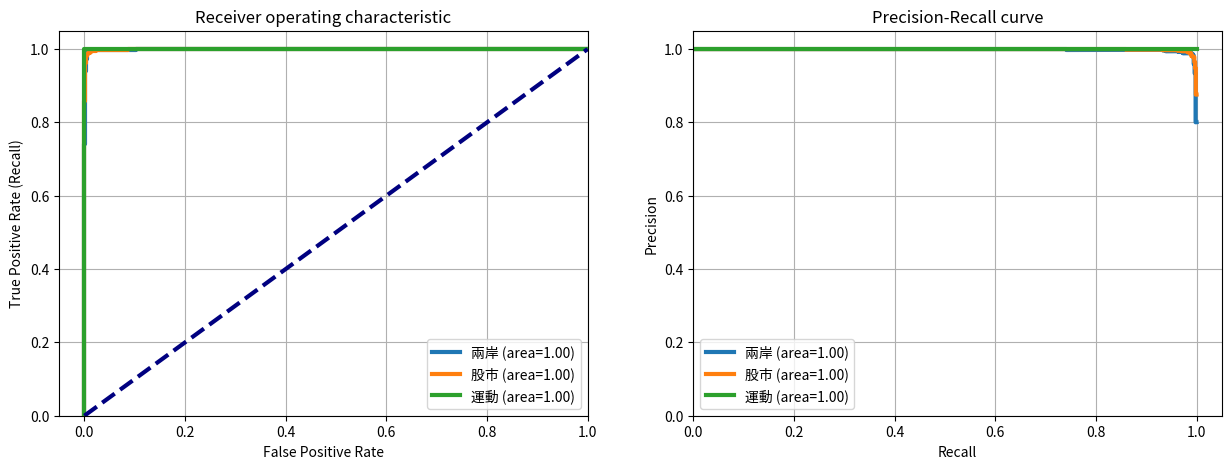

now training: clf_dtree
              precision    recall  f1-score   support

          兩岸       0.95      0.92      0.94       526
          股市       0.95      0.96      0.96       677
          運動       0.97      0.98      0.98       593

    accuracy                           0.96      1796
   macro avg       0.96      0.96      0.96      1796
weighted avg       0.96      0.96      0.96      1796



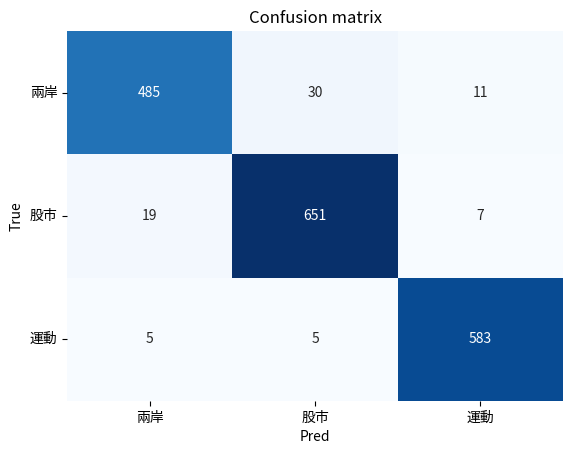

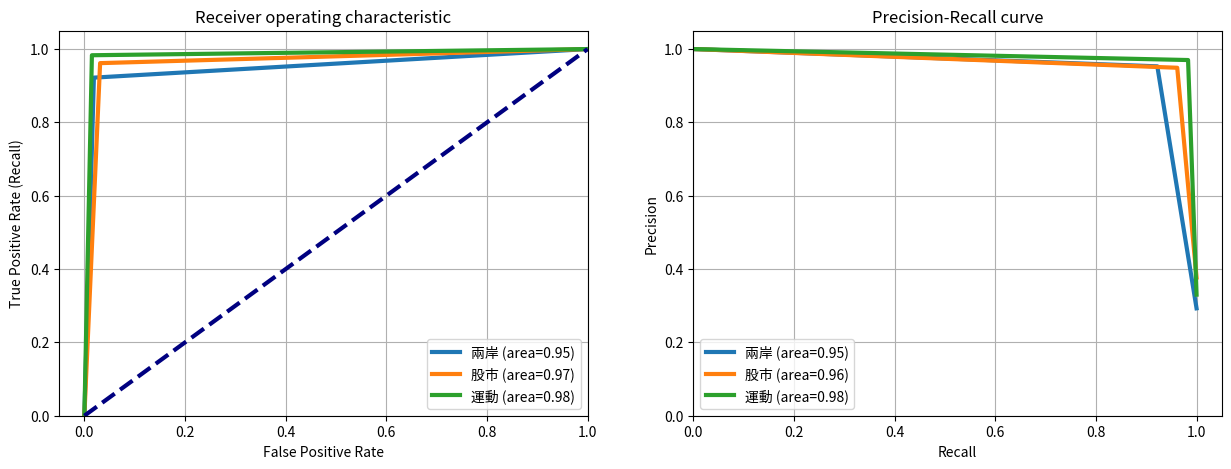

now training: clf_nb
              precision    recall  f1-score   support

          兩岸       0.97      0.95      0.96       526
          股市       0.97      0.97      0.97       677
          運動       0.98      1.00      0.99       593

    accuracy                           0.97      1796
   macro avg       0.97      0.97      0.97      1796
weighted avg       0.97      0.97      0.97      1796



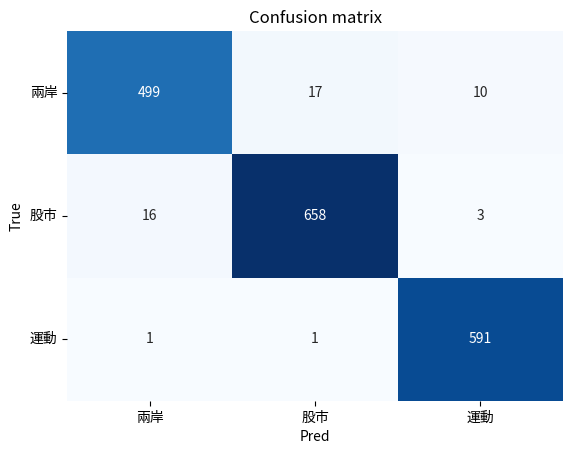

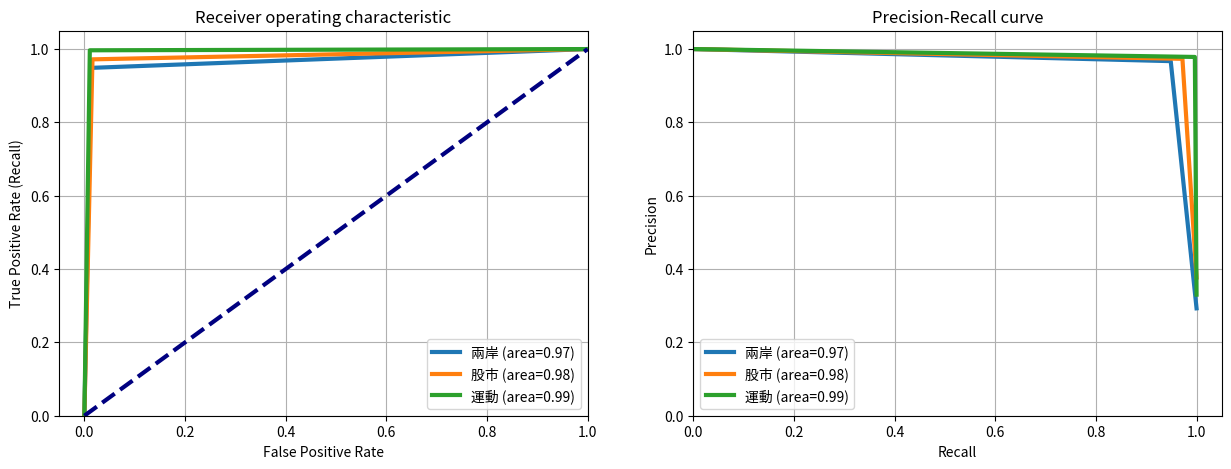

now training: clf_gb
              precision    recall  f1-score   support

          兩岸       0.98      0.98      0.98       526
          股市       0.99      0.99      0.99       677
          運動       1.00      0.99      0.99       593

    accuracy                           0.99      1796
   macro avg       0.99      0.99      0.99      1796
weighted avg       0.99      0.99      0.99      1796



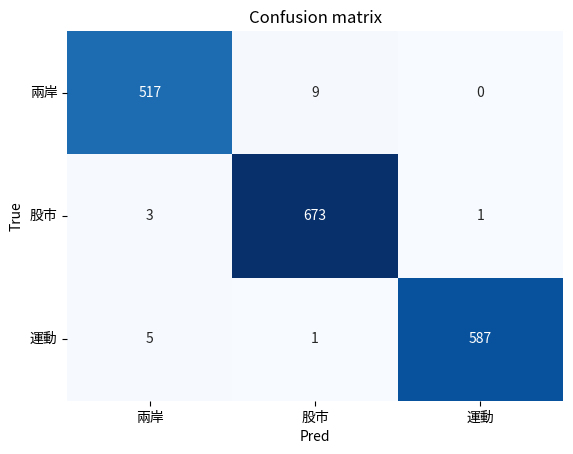

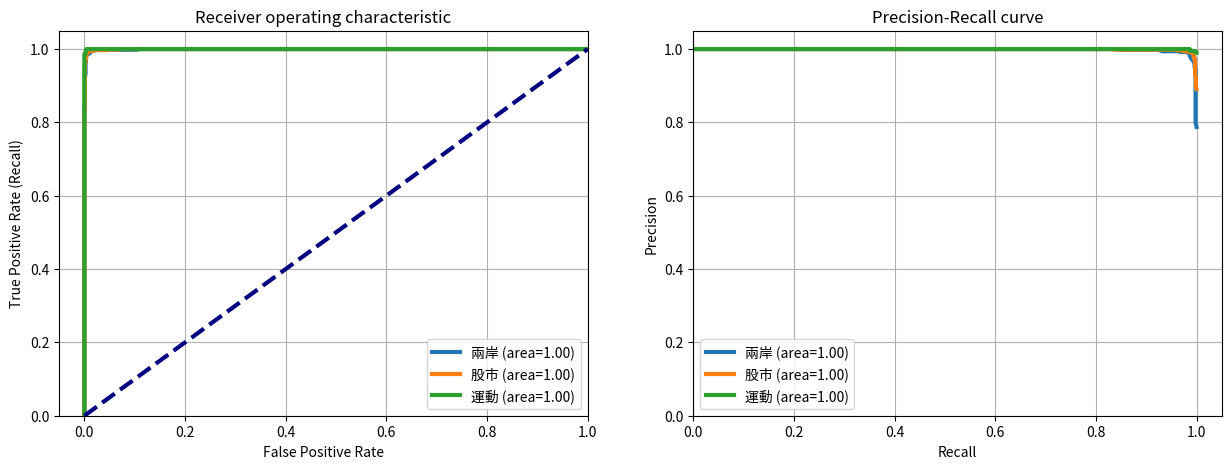

In [56]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression(multi_class="multinomial")
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_nb'] = GaussianNB()
model_set['clf_gb'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train(vectorizer, model, X_train, y_train, X_test, y_test)
    print("="*100)


In [57]:
result_set['clf_logistic']

{'兩岸': {'precision': 0.9848484848484849,
  'recall': 0.9885931558935361,
  'f1-score': 0.9867172675521821,
  'support': 526},
 '股市': {'precision': 0.9896907216494846,
  'recall': 0.9926144756277696,
  'f1-score': 0.9911504424778761,
  'support': 677},
 '運動': {'precision': 1.0,
  'recall': 0.9932546374367622,
  'f1-score': 0.9966159052453468,
  'support': 593},
 'accuracy': 0.9916481069042317,
 'macro avg': {'precision': 0.9915130688326564,
  'recall': 0.9914874229860228,
  'f1-score': 0.991494538425135,
  'support': 1796},
 'weighted avg': {'precision': 0.99167645968096,
  'recall': 0.9916481069042317,
  'f1-score': 0.991656661525869,
  'support': 1796}}

In [58]:
max = 0
best_model_name = ""

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg']['f1-score'] > max:
        max = v['macro avg']['f1-score']
        best_model_name = k
print(best_model_name)
print(result_set[best_model_name])

clf_logistic
{'兩岸': {'precision': 0.9848484848484849, 'recall': 0.9885931558935361, 'f1-score': 0.9867172675521821, 'support': 526}, '股市': {'precision': 0.9896907216494846, 'recall': 0.9926144756277696, 'f1-score': 0.9911504424778761, 'support': 677}, '運動': {'precision': 1.0, 'recall': 0.9932546374367622, 'f1-score': 0.9966159052453468, 'support': 593}, 'accuracy': 0.9916481069042317, 'macro avg': {'precision': 0.9915130688326564, 'recall': 0.9914874229860228, 'f1-score': 0.991494538425135, 'support': 1796}, 'weighted avg': {'precision': 0.99167645968096, 'recall': 0.9916481069042317, 'f1-score': 0.991656661525869, 'support': 1796}}


可以看到過濾詞頻之後，字詞的維度減少，不過準確度也稍微下降了，同學可以自行嘗試是否依據詞頻過濾，或調整詞頻過濾的大小，看看模型的準確度會有什麼樣的變化

### 4.3. 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

### 5.4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 5.1 的 logistic regression + cv tokenizer 為例

In [60]:
def plot_coef(logreg_coef):
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = (
            logreg_coef[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, 6))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

In [61]:
log_odds = model_set['clf_logistic'].coef_.T
coef_df = pd.DataFrame(
    log_odds, 
    columns=model_set['clf_logistic'].classes_, index=vectorizer.get_feature_names()
)
coef_df.head()

,兩岸,股市,運動
一三壘,-0.024106,-0.018026,0.042132
一下,-0.157222,-0.024272,0.181494
一中,0.021850,-0.036527,0.014676
一事,0.089762,-0.068849,-0.020913
一些,0.558244,-0.403944,-0.154300


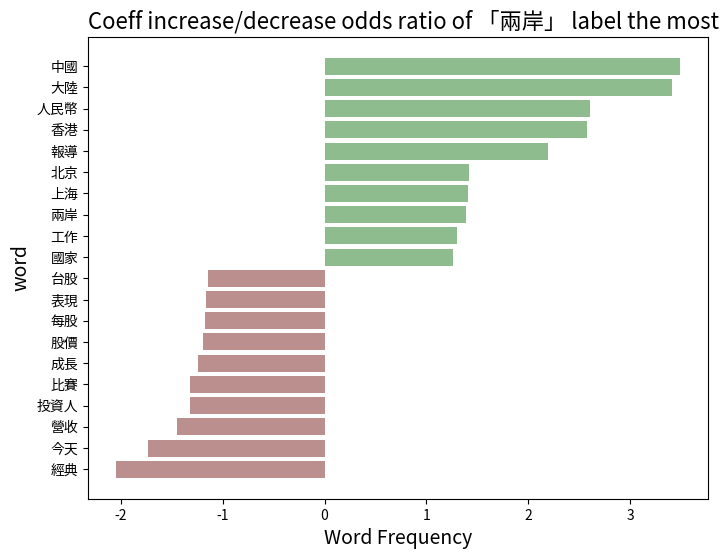

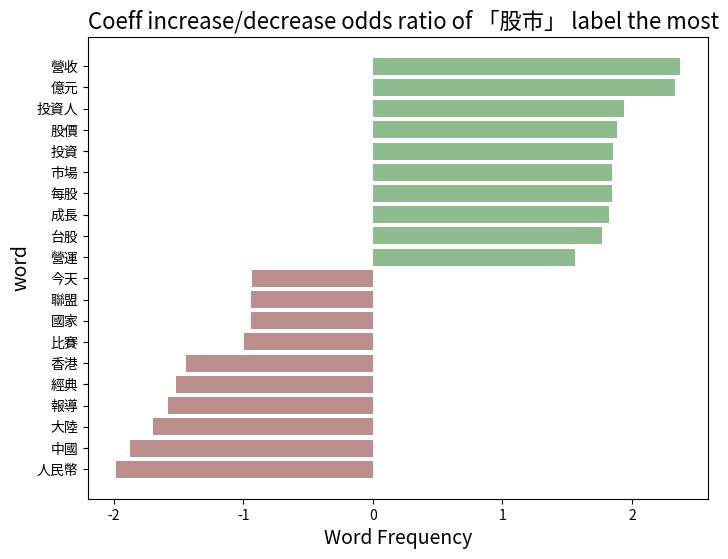

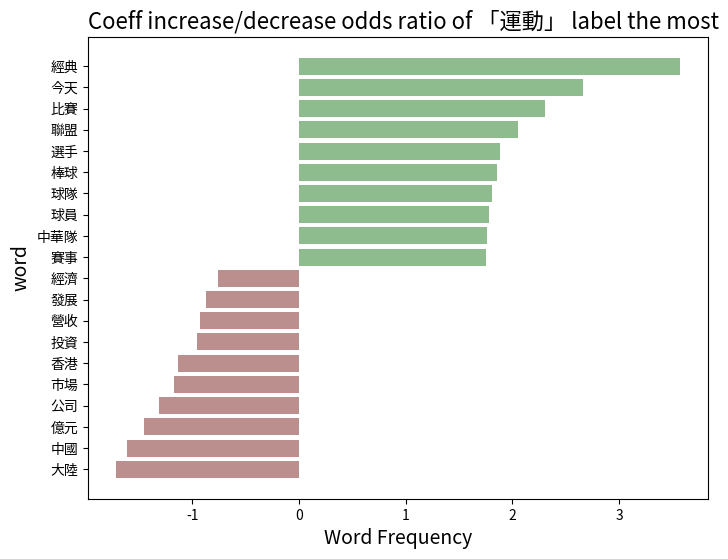

In [62]:
plot_coef(coef_df)

「舞弊」、「被動」 等字是影響判斷為負面情緒的重要字；「自豪」字是影響判斷為正面句子的重要字詞。

### 預測新聞類別

In [63]:
ct = pd.read_csv("./raw_data/ct_news_04.csv")
ct = ct.groupby("artCatagory").head(3)
ct

,system_id,artUrl,artCatagory,artTitle,artDate,artContent,dataSource
0,1,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 蔡總統雷根圖書館演說恐生變,2023-04-01 04:10:00,蔡英文總統出訪中美洲友邦途中過境美國，美東時間3月30日晚間，在紐約受邀出席美國「哈德遜研究...,chinatimes
1,2,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯聯盟第1波 10藍委籲黨中央速徵召,2023-04-01 04:10:00,國民黨2024總統大選將以徵召方式決定人選，黨中央雖已積極展開徵詢，但目前黨內最強母雞就是新...,chinatimes
2,3,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥黨員投票水很深 宣布退選,2023-04-01 04:10:00,國民黨立委初選內鬥不斷，台北市第8選區（中正、文山）初選方式採37制，原本有意投入初選的北市...,chinatimes
71,72,https://www.chinatimes.com/newspapers/20230401...,娛樂,阿妹霸秀鉛筆腿 誇雄蛋地板很Man,2023-04-01 04:10:00,張惠妹3月31日起，在高雄巨蛋連辦10場「aMEI ASMR世界巡迴演唱會」，不同去年4月台...,chinatimes
72,73,https://www.chinatimes.com/newspapers/20230401...,娛樂,温昇豪誇AKIRA苦過懂得體貼,2023-04-01 04:10:00,「國民姊夫」AKIRA首次主持的衛視中文台實境節目《神秘五金行》，並與王陽明、温昇豪、禾浩辰...,chinatimes
73,74,https://www.chinatimes.com/newspapers/20230401...,娛樂,《淡水小鎮》嫁女兒黃嘉千入戲噴淚,2023-04-01 04:10:00,黃嘉千、李千娜、蔡旻佑、卜學亮等人主演果陀劇場舞台劇《淡水小鎮》3月31日總彩排。黃嘉千戲裡...,chinatimes
151,152,https://www.chinatimes.com/newspapers/20230401...,財經,16檔WIN贏家概念股 出列,2023-04-01 04:10:00,美國銀行業危機緩和，市場押注聯準會將在5月最後升息，激勵資金回籠股市。上市櫃公司陸續公布財報...,chinatimes
152,153,https://www.chinatimes.com/newspapers/20230401...,財經,上市櫃去年獲利 跌破4兆元,2023-04-01 04:10:00,疫情紅利消退、金融業防疫保單及債券評價減損等衝擊，台股上市櫃公司2022年獲利跌破4兆至3....,chinatimes
153,154,https://www.chinatimes.com/newspapers/20230401...,財經,跟隨美國腳步，劍指中國 日本限制23項半導體設備出口,2023-04-01 04:10:00,日本經濟產業大臣西村康稔在新聞稿中指出，日本將對用來製造晶片的6類設備實施出口管制，當中包括...,chinatimes
294,295,https://www.chinatimes.com/newspapers/20230401...,兩岸,馬英九搭高鐵返湘潭祭祖 宋濤一路相陪,2023-04-01 04:10:00,前總統馬英九的訪陸之行今天將進入重頭戲，由大陸國台辦主任宋濤陪同，和4名姐妹一起回到湖南湘潭...,chinatimes


In [64]:
# 移除網址格式
ct["artContent"] = ct.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ct["artTitle"] = ct["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ct["artContent"] = ct.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ct["artTitle"] = ct["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,外媒爆蔡總統雷根圖書館演說恐生變蔡英文總統出訪中美洲友邦途中過境美國美東時間月日晚間在紐約受...,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...
1,挺侯聯盟第波藍委籲黨中央速徵召國民黨總統大選將以徵召方式決定人選黨中央雖已積極展開徵詢但目前...,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯 聯盟 第波 藍委籲 黨中央 徵召 國民黨 總統大選 將以 徵召 方式 決定 人選 黨中...
2,徐弘庭斥黨員投票水很深宣布退選國民黨立委初選內鬥不斷台北市第選區中正文山初選方式採制原本有意...,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 正文 初選 方式 ...
71,阿妹霸秀鉛筆腿誇雄蛋地板很張惠妹月日起在高雄巨蛋連辦場世界巡迴演唱會不同去年月台北小巨蛋開唱...,https://www.chinatimes.com/newspapers/20230401...,娛樂,阿妹 霸秀 鉛筆 誇雄蛋 地板 張惠妹 高雄 巨蛋 連辦場 世界 巡迴演唱 去年 台北 巨蛋...
72,温昇豪誇苦過懂得體貼國民姊夫首次主持的衛視中文台實境節目神秘五金行並與王陽明温昇豪禾浩辰王彩...,https://www.chinatimes.com/newspapers/20230401...,娛樂,誇苦過 懂得 體貼 國民 姊夫 首次 主持 衛視 中文台 實境 節目 神秘 五金 行並 王陽...


In [65]:
ct['artCatagory'].value_counts()

政治    3
娛樂    3
財經    3
兩岸    3
體育    3
Name: artCatagory, dtype: int64

In [66]:
X = ct['words']
y_pred = model_set[best_model_name].predict(vectorizer.transform(X))
ct['pred'] = y_pred

In [67]:
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...,政治,兩岸
1,挺侯 聯盟 第波 藍委籲 黨中央 徵召 國民黨 總統大選 將以 徵召 方式 決定 人選 黨中...,政治,兩岸
2,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 正文 初選 方式 ...,政治,兩岸
71,阿妹 霸秀 鉛筆 誇雄蛋 地板 張惠妹 高雄 巨蛋 連辦場 世界 巡迴演唱 去年 台北 巨蛋...,娛樂,兩岸
72,誇苦過 懂得 體貼 國民 姊夫 首次 主持 衛視 中文台 實境 節目 神秘 五金 行並 王陽...,娛樂,兩岸
73,淡水 小鎮 女兒 嘉千入 戲噴淚 嘉千 李千娜 蔡旻佑 卜學亮 主演 果陀 劇場 舞台 淡水...,娛樂,兩岸
151,贏家 概念股 出列 美國 銀行業 危機 緩和 市場 押注 聯準 會將 最後 升息 激勵 資金...,財經,股市
152,上市 去年 獲利 跌破 兆元 疫情 紅利 消退 金融業 防疫 保單 債券 評價 減損 衝擊 ...,財經,股市
153,跟隨 美國 腳步 中國 日本 限制 半導體 設備 出口 日本 經濟 產業 大臣 西村 康稔 ...,財經,兩岸
294,馬英九 高鐵 湘潭 祭祖 宋濤 一路 相陪 總統 馬英九 訪陸 之行 天將 進入 重頭戲 大...,兩岸,兩岸


In [68]:
ct['words'][73]

'淡水 小鎮 女兒 嘉千入 戲噴淚 嘉千 李千娜 蔡旻佑 卜學亮 主演 果陀 劇場 舞台 淡水 小鎮 彩排 嘉千戲裡 卜學亮 夫妻 看著 獨生女 李千娜 出嫁 激動 落淚 談到 女兒 橋段 千把 人母 心境 投射 特別 想到 心疼 問到 離婚 官司 進度 她僅 不好意思 迅速 工作人員 帶離 現場 嘉千 卜學亮 先前 舞台 劇吻 娜娜 搭檔 夫妻 這回 再續 前緣 導演 志民 笑稱 人梅 開度 嘉千 打趣 這回 夫妻關係 改善 上次 爭鋒 相對 這次 甜蜜 恩愛 爆料 卜學亮 戲常給 驚喜 措手不及 每次 親吻 時間 點都 不講 直接 這次 溫柔 又親'

模型大致上的預測結果還算不錯

accuracy可能會因為正負面資料分布不同而有所偏差，所以選擇模型的時候，可以加入一起 AUC 評估。在這裡可以看到個模型在三種情緒的AUC指標都不會相差太多，對於AUC來說，整體而言 TF-IDF + SVC 的表現較好。若以準確率來看，CV + RandomForest 表現最好。

## 結論
1. 各情緒的字詞分佈有甚麼不同，代表字詞有哪些？
2. 如果用詞頻建立DTM，需不需要篩選詞頻？
3. 此資料集用什麼樣的模型預測，準確率會較高？

## 附錄

    畫出決策樹的 code

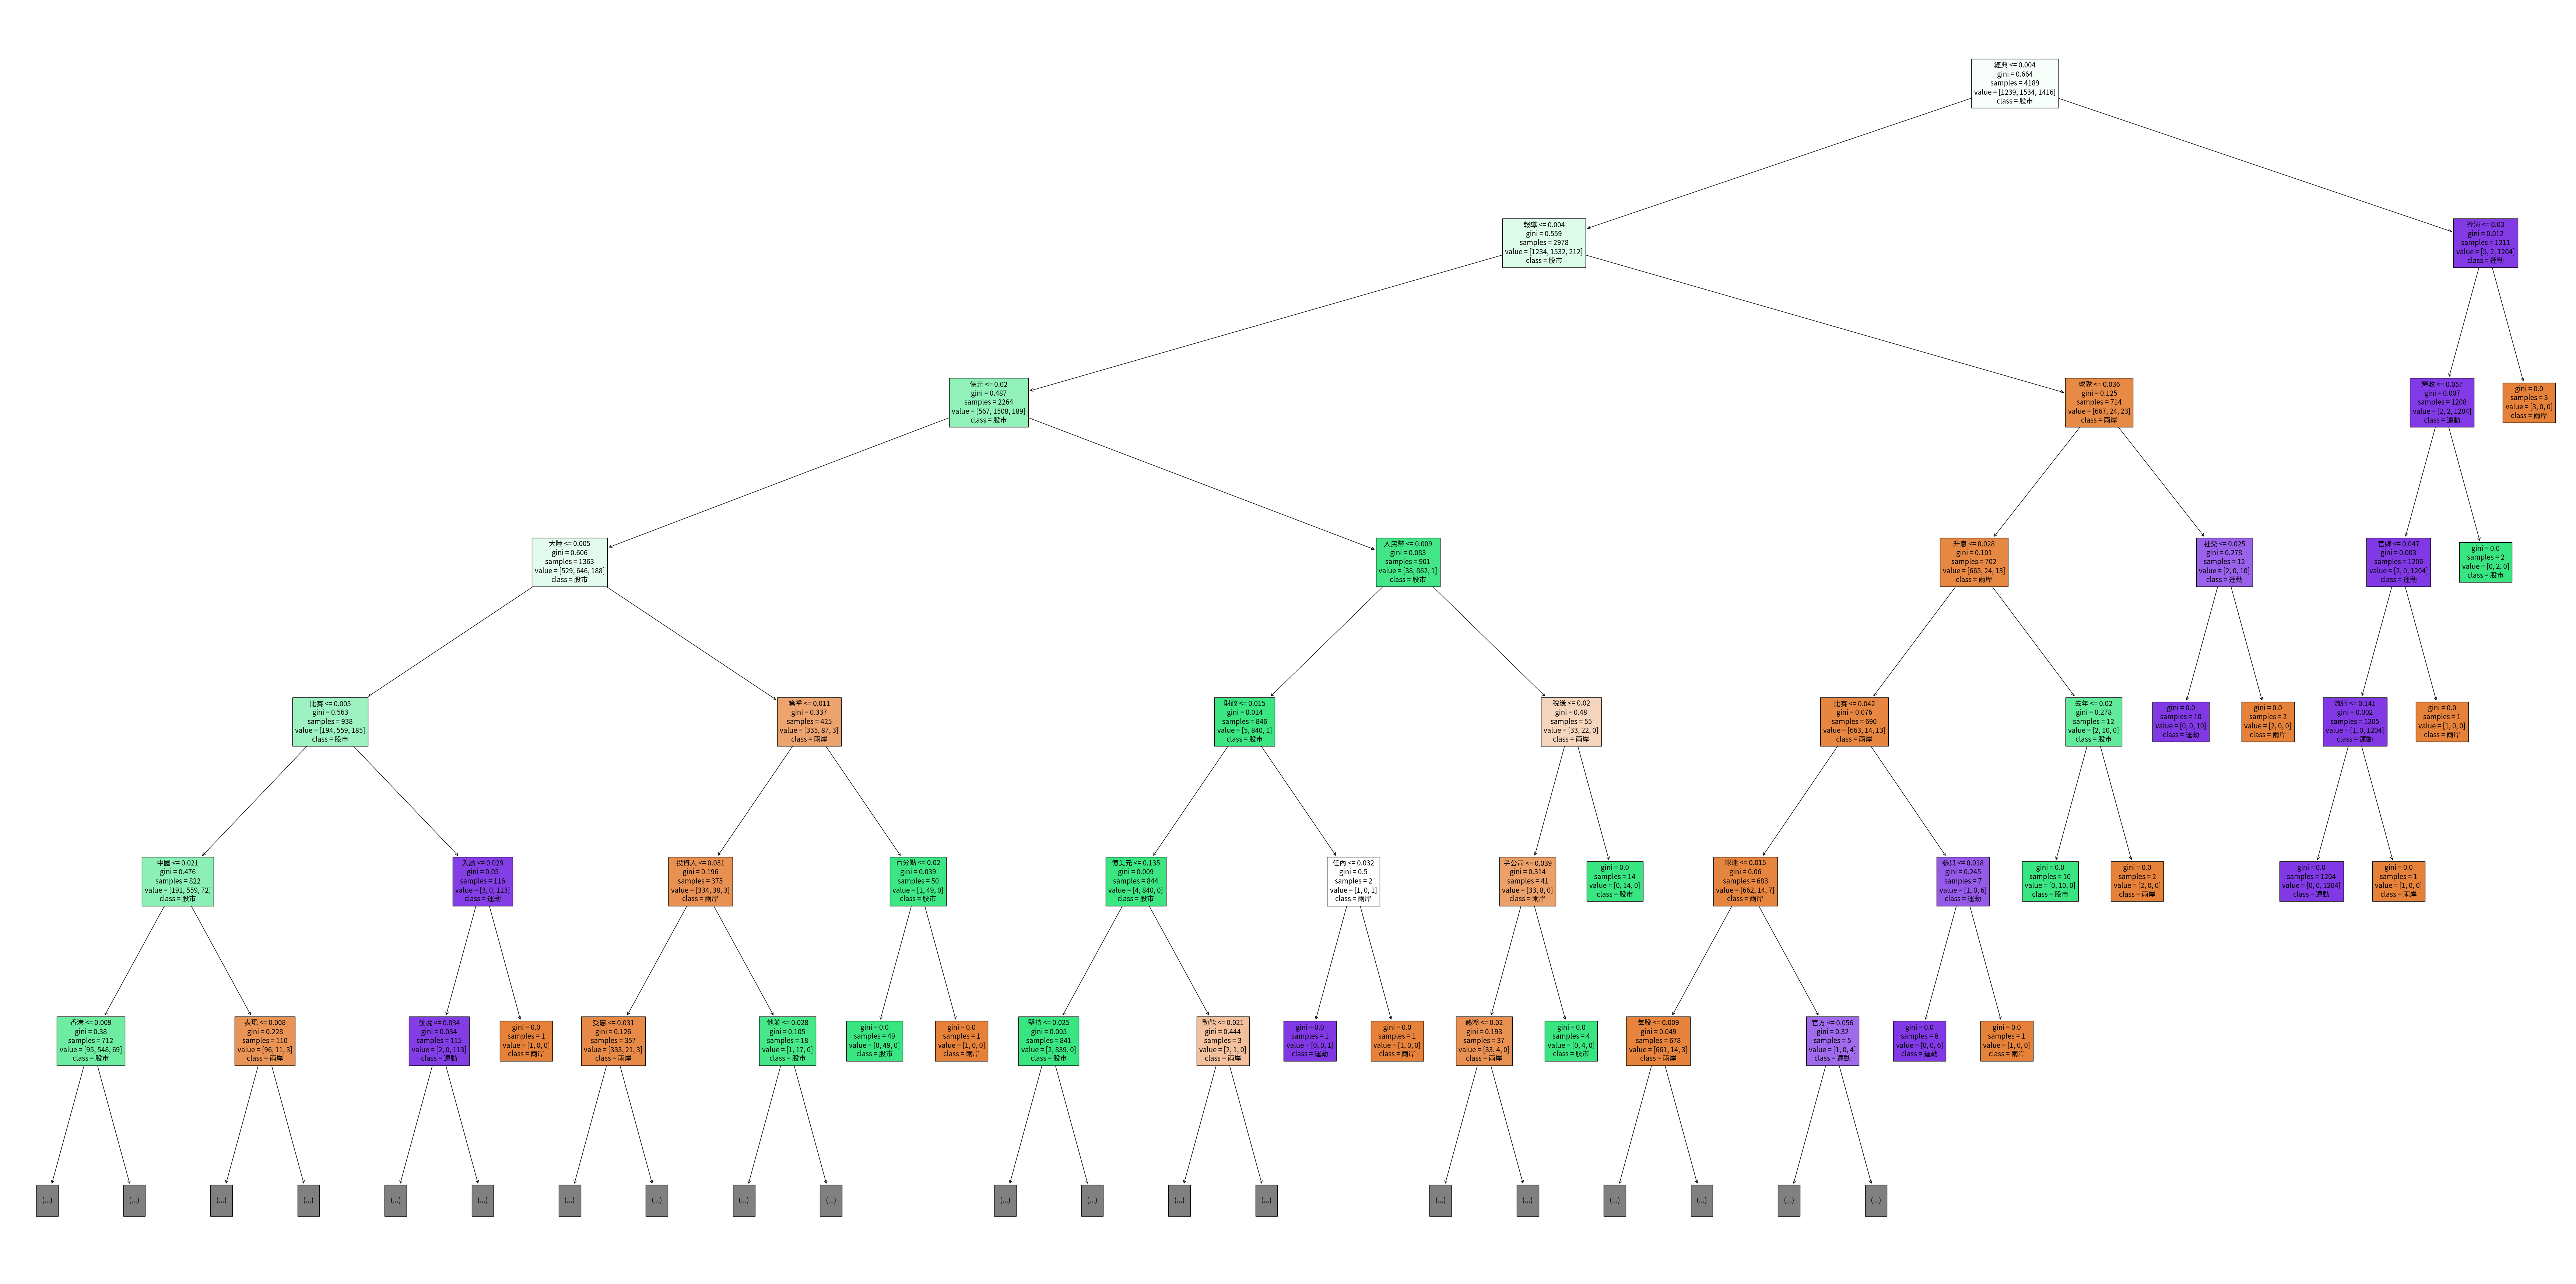

In [59]:
fig = plt.figure()
fig.set_size_inches(90, 45)
plot_tree(
    model_set["clf_dtree"], 
    max_depth=6, # 最大深度
    feature_names=vectorizer.get_feature_names(), 
    class_names=model_set["clf_dtree"].classes_,
    filled=True
)
fig.savefig("decistion_tree.png")